# Connect to Google Drive

In [0]:
#Step 1 part 1: connect to drive
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 130911 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.3-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=of

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

# CNN Model

In [0]:
import numpy as np
import pandas as pd
import os
import cv2
import glob
from os import listdir
from os.path import isfile, join
from os import walk
from random import sample
import pickle, cv2
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras import applications, optimizers
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense
from keras.models import model_from_json
from keras.models import load_model
from keras.utils import plot_model
import json

Using TensorFlow backend.


In [0]:
data_root = 'drive/ML-Kaggle/'

In [0]:
model = Sequential()
model.add(Convolution2D(filters=32, kernel_size=(3,3), input_shape=(224,224,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Convolution2D(32,3,3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(units=3, activation = 'softmax'))

sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`
  after removing the cwd from sys.path.


In [0]:
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.1, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data = '{}{}'.format(data_root,'training_set/')
test_data = '{}{}'.format(data_root,'test_set/')

training_set = train_datagen.flow_from_directory(train_data, target_size=(224,224), batch_size=32, class_mode='categorical')
test_set = test_datagen.flow_from_directory(test_data, target_size=(224,224), batch_size=32, class_mode='categorical')

Found 1500 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


In [0]:
classes = training_set.class_indices
print(classes)

{'Expressionism': 0, 'Impressionism': 1, 'Surrealism': 2}


In [0]:
print(training_set)
print(test_set)

In [0]:
model.fit_generator(training_set, samples_per_epoch=100, nb_epoch=30, validation_data=test_set, nb_val_samples=300)

Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=<keras_pre..., steps_per_epoch=3, epochs=30, validation_steps=300)`
  """Entry point for launching an IPython kernel.


Epoch 1/30
1/3 [=========>....................] - ETA: 56s - loss: 1.0972 - acc: 0.3125

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2496: DecompressionBombWarning: Image size (145486286 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


3/3 [==============================] - 737s 246s/step - loss: 1.0902 - acc: 0.3958 - val_loss: 1.1034 - val_acc: 0.3367
Epoch 2/30
3/3 [==============================] - 566s 189s/step - loss: 1.1180 - acc: 0.2917 - val_loss: 1.0980 - val_acc: 0.3367
Epoch 3/30
3/3 [==============================] - 565s 188s/step - loss: 1.1059 - acc: 0.2604 - val_loss: 1.0980 - val_acc: 0.3500
Epoch 4/30
3/3 [==============================] - 564s 188s/step - loss: 1.1065 - acc: 0.3542 - val_loss: 1.0984 - val_acc: 0.3400
Epoch 5/30
3/3 [==============================] - 564s 188s/step - loss: 1.1012 - acc: 0.4062 - val_loss: 1.0971 - val_acc: 0.3433
Epoch 6/30
3/3 [==============================] - 666s 222s/step - loss: 1.1035 - acc: 0.2917 - val_loss: 1.0974 - val_acc: 0.3867
Epoch 7/30
3/3 [==============================] - 917s 306s/step - loss: 1.0946 - acc: 0.3438 - val_loss: 1.0986 - val_acc: 0.3600
Epoch 8/30
3/3 [==============================] - 979s 326s/step - loss: 1.0992 - acc: 0.3750 

In [0]:
plot_model(model, to_file='drive/ML-Kaggle/model.pdf')

In [0]:
def load_model():
    json_file = open('drive/ML-Kaggle/second_model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()

    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights('drive/ML-Kaggle/second_model_weights.h5')

    sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
    loaded_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

    return loaded_model

In [0]:
model = load_model()

In [0]:
history = model.fit_generator(training_set, samples_per_epoch=100, nb_epoch=15, validation_data=test_set, nb_val_samples=300)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=<keras_pre..., steps_per_epoch=3, epochs=15, validation_steps=300)`
  """Entry point for launching an IPython kernel.


Epoch 1/15
2/3 [===================>..........] - ETA: 20s - loss: 1.0911 - acc: 0.2812

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2496: DecompressionBombWarning: Image size (145486286 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


3/3 [==============================] - 637s 212s/step - loss: 1.1003 - acc: 0.2812 - val_loss: 1.0808 - val_acc: 0.3500
Epoch 2/15
3/3 [==============================] - 545s 182s/step - loss: 1.0795 - acc: 0.3958 - val_loss: 1.0786 - val_acc: 0.3967
Epoch 3/15
3/3 [==============================] - 550s 183s/step - loss: 1.0824 - acc: 0.4271 - val_loss: 1.0776 - val_acc: 0.4200
Epoch 4/15
3/3 [==============================] - 630s 210s/step - loss: 1.0840 - acc: 0.3958 - val_loss: 1.0771 - val_acc: 0.4033
Epoch 5/15
3/3 [==============================] - 852s 284s/step - loss: 1.0788 - acc: 0.3750 - val_loss: 1.0768 - val_acc: 0.3800
Epoch 6/15
3/3 [==============================] - 977s 326s/step - loss: 1.0993 - acc: 0.3229 - val_loss: 1.0748 - val_acc: 0.4100
Epoch 7/15
3/3 [==============================] - 1095s 365s/step - loss: 1.0595 - acc: 0.5208 - val_loss: 1.0781 - val_acc: 0.3900
Epoch 8/15
3/3 [==============================] - 1108s 369s/step - loss: 1.0811 - acc: 0.406

In [0]:
save_model_path = '{}{}'.format(data_root,'second_model.json')
save_model_weight = '{}{}'.format(data_root,'second_model_weights.h5')
history_path = '{}{}'.format(data_root,'history_2.json')

In [0]:
open(save_model_path, 'w').close()
open(save_model_weight, 'w').close()

model_json = model.to_json()
with open(save_model_path, 'w') as json_file:
    json_file.write(model_json)

model.save_weights(save_model_weight)
print('Model saved to disk!')

with open(history_path, 'w') as f:
    json.dump(history.history, f)
print('History saved to disk!')

Model saved to disk!
History saved to disk!


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


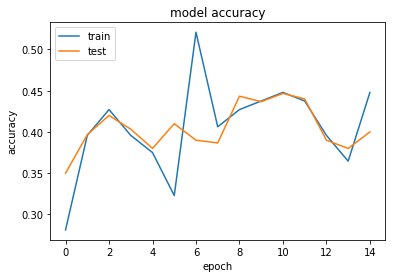

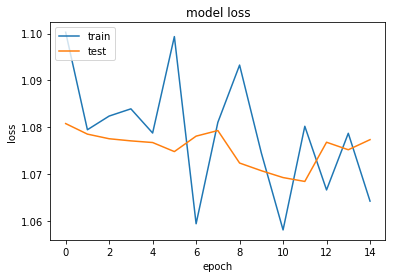

In [0]:
print(history.history.keys())

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
model = load_model()

In [0]:
history = model.fit_generator(training_set, samples_per_epoch=100, nb_epoch=10, validation_data=test_set, nb_val_samples=300)

Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=<keras_pre..., steps_per_epoch=3, epochs=10, validation_steps=300)`
  """Entry point for launching an IPython kernel.


Epoch 1/10


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2496: DecompressionBombWarning: Image size (145486286 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


3/3 [==============================] - 738s 246s/step - loss: 1.0739 - acc: 0.4062 - val_loss: 1.0764 - val_acc: 0.4000
Epoch 2/10
3/3 [==============================] - 883s 294s/step - loss: 1.0412 - acc: 0.4479 - val_loss: 1.0666 - val_acc: 0.3800
Epoch 3/10
3/3 [==============================] - 963s 321s/step - loss: 1.0821 - acc: 0.3958 - val_loss: 1.0661 - val_acc: 0.3933
Epoch 4/10
3/3 [==============================] - 1104s 368s/step - loss: 1.0360 - acc: 0.5312 - val_loss: 1.0683 - val_acc: 0.4233
Epoch 5/10
3/3 [==============================] - 1311s 437s/step - loss: 1.0681 - acc: 0.4896 - val_loss: 1.0605 - val_acc: 0.4233
Epoch 6/10
3/3 [==============================] - 1486s 495s/step - loss: 1.0728 - acc: 0.3958 - val_loss: 1.0578 - val_acc: 0.4367
Epoch 7/10
3/3 [==============================] - 1558s 519s/step - loss: 1.0644 - acc: 0.3750 - val_loss: 1.0556 - val_acc: 0.4433
Epoch 8/10
3/3 [==============================] - 1879s 626s/step - loss: 1.0791 - acc: 0.

In [0]:
save_model_path = '{}{}'.format(data_root,'third_model.json')
save_model_weight = '{}{}'.format(data_root,'third_model_weights.h5')
history_path = '{}{}'.format(data_root,'history_3.json')

In [0]:
open(save_model_path, 'w').close()
open(save_model_weight, 'w').close()

model_json = model.to_json()
with open(save_model_path, 'w') as json_file:
    json_file.write(model_json)

model.save_weights(save_model_weight)
print('Model saved to disk!')

with open(history_path, 'w') as f:
    json.dump(history.history, f)
print('History saved to disk!')

Model saved to disk!
History saved to disk!


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


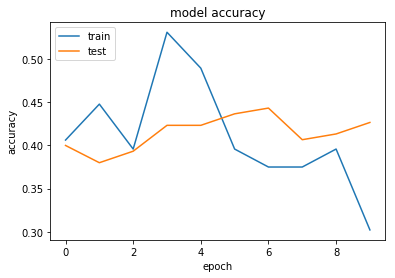

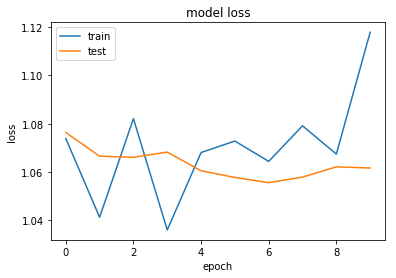

In [0]:
print(history.history.keys())

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Predict

In [0]:
def load_model_to_predict():
    json_file = open('drive/ML-Kaggle/third_model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()

    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights('drive/ML-Kaggle/third_model_weights.h5')

    sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
    loaded_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

    return loaded_model

model = load_model_to_predict()

In [0]:
def make_prediction(img_path):
    
    img = cv2.imread(img_path, 1)
    img = cv2.resize(img,(224,224))
    img = np.reshape(img,[1,224,224,3])

    preds = model.predict_classes(img)

    return preds

In [0]:
img_path_imp = 'drive/ML-Kaggle/UnseenData/Impressionism/'
    
imp = []

for root, dirs, files in os.walk(img_path_imp):  
    for filename in files:
        imp.append(filename)

print("Impressionism\n")

results = []

for f in imp:
    str = img_path_imp + f
    x = make_prediction(str)
    
    if x==[0]:
        results.append("Expressionism")
    elif x==[1]:
        results.append("Impressionism")
    elif x==[2]:
        results.append("Surrealism")
        
print(len(results))

count_im = 0

for i in range(0,211):
    if results[i] == "Impressionism":
        count_im += 1
        
accuracy = count_im/len(results)
print(accuracy)

Impressionism

211
0.1895734597156398


In [0]:
img_path_imp = 'drive/ML-Kaggle/UnseenData/Expressionism/'
    
imp = []

for root, dirs, files in os.walk(img_path_imp):  
    for filename in files:
        imp.append(filename)

print("Expressionism\n")

results = []

for f in imp:
    str = img_path_imp + f
    x = make_prediction(str)
    
    #print(x)
    
    if x==[0]:
        results.append("Expressionism")
    elif x==[1]:
        results.append("Impressionism")
    elif x==[2]:
        results.append("Surrealism")
        
print(len(results))

count_ex = 0

for i in range(0,len(results)):
    if results[i] == "Expressionism":
        count_ex += 1
        
accuracy = count_ex/len(results)
print(accuracy)

Expressionism

200
0.0


In [0]:
img_path_imp = 'drive/ML-Kaggle/UnseenData/Surrealism/'
    
imp = []

for root, dirs, files in os.walk(img_path_imp):  
    for filename in files:
        imp.append(filename)

print("Surrealism\n")

results = []

for f in imp:
    str = img_path_imp + f
    x = make_prediction(str)
    
    if x==[0]:
        results.append("Expressionism")
    elif x==[1]:
        results.append("Impressionism")
    elif x==[2]:
        results.append("Surrealism")
        
print(len(results))

count_su = 0

for i in range(0,len(results)):
    if results[i] == "Surrealism":
        count_su += 1
        
accuracy = count_su/len(results)
print(accuracy)

Surrealism

205
0.8975609756097561


In [0]:
final_accuracy = (count_im+count_ex+count_su)/(211+200+205)
print(final_accuracy)

0.36363636363636365
